In [1]:
#Import packages used here:
# for initial data exploration:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from IPython.display import Image, display
import random
import math

#For modeling and model viewing. 
import tensorflow as tf
from keras.preprocessing.image import load_img,img_to_array,ImageDataGenerator
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.utils import plot_model 
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Activation,Concatenate
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.utils import to_categorical #Image generator used for transformation to categorical
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ReduceLROnPlateau
from tensorflow.keras import backend, models
#from sklearn.model_selection import train_test_split  #could have used on the consolidated file.
from sklearn.metrics import confusion_matrix

from tensorflow.keras.applications import VGG16, MobileNet
#from keras.applications.vgg16 import decode_predictions
from keras.applications.vgg16 import preprocess_input

from google.colab import drive

In [2]:
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [3]:
cwd = os.getcwd()
print(cwd)

/content


In [4]:
path = cwd + '/drive/MyDrive/Birds_Identification/data/train/'
print(path)

/content/drive/MyDrive/Birds_Identification/data/train/


In [5]:
#This will setup my directories for all of the data files in the 100-bird-species dataset. 
BASE_DIR = cwd+'/drive/MyDrive/Birds_Identification/data/'
print('BASE_DIR contains ', os.listdir(BASE_DIR))
TRAIN_DIR = os.path.join(BASE_DIR, 'train')
VALIDATION_DIR = os.path.join(BASE_DIR, 'valid')
TEST_DIR = os.path.join(BASE_DIR, 'test')

BASE_DIR contains  ['train', 'test', 'valid']


In [6]:
CATEGORIES = os.listdir(TRAIN_DIR)
print(str(len(CATEGORIES)),'CATEGORIES are ', CATEGORIES)

Category_count = len(CATEGORIES)

59 CATEGORIES are  ['CALIFORNIA QUAIL', 'CANARY', 'CAPUCHINBIRD', 'BULWERS PHEASANT', 'CASPIAN TERN', 'CAPE MAY WARBLER', 'CACTUS WREN', 'CALIFORNIA CONDOR', 'CARMINE BEE-EATER', 'CALIFORNIA GULL', 'BROWN THRASHER', 'BLACKBURNIAM WARBLER', 'BORNEAN LEAFBIRD', 'BOBOLINK', 'BLACK-NECKED GREBE', 'BORNEAN BRISTLEHEAD', 'BLUE HERON', 'BLACK-THROATED SPARROW', 'BLUE GROUSE', 'BROWN NOODY', 'BLACK-CAPPED CHICKADEE', 'BLACK SKIMMER', 'BLACK SWAN', 'BLACK VULTURE', 'BIRD OF PARADISE', 'BLACK FRANCOLIN', 'BLACK THROATED BUSHTIT', 'BLACK THROATED WARBLER', 'BLACK & YELLOW bROADBILL', 'BLACK TAIL CRAKE', 'BARN SWALLOW', 'BARRED PUFFBIRD', 'BANANAQUIT', 'BEARDED REEDLING', 'BELTED KINGFISHER', 'BARN OWL', 'BAY-BREASTED WARBLER', 'BANDED BROADBILL', 'BEARDED BARBET', 'BAR-TAILED GODWIT', 'AMERICAN REDSTART', 'ANNAS HUMMINGBIRD', 'BALI STARLING', 'ANTBIRD', 'ARARIPE MANAKIN', 'BALTIMORE ORIOLE', 'ASIAN CRESTED IBIS', 'BALD EAGLE', 'ANHINGA', 'AMERICAN PIPIT', 'AMERICAN KESTREL', 'AFRICAN CROWNED CRAN

In [8]:
# # let's display some of the pictures

# for category in CATEGORIES:
#     fig, _ = plt.subplots(1,5)
#     fig.suptitle(category)
#     fig.patch.set_facecolor('xkcd:green')
#     for k, v in enumerate(os.listdir(path+category)[10:15]):
#         img = plt.imread(path+category+'/'+v)
#         plt.subplot(1, 5, k+1)
#         plt.axis('off')
#         plt.imshow(img)
#     plt.show()



In [10]:
# shape0 = []
# shape1 = []

# for category in CATEGORIES:
#     for files in os.listdir(path+category):
#         shape0.append(plt.imread(path+category+'/'+ files).shape[0])
#         shape1.append(plt.imread(path+category+'/'+ files).shape[1])
#     print(category, ' => height min : ', min(shape0), 'width min : ', min(shape1))
#     print(category, ' => height max : ', max(shape0), 'width max : ', max(shape1))
#     shape0 = []
#     shape1 = []

In [11]:
General_datagen = ImageDataGenerator(rescale=1./255, )

In [12]:
train_data = General_datagen.flow_from_directory(TRAIN_DIR, target_size=(224,224))
print('data groups:', len(train_data)) #Will be used to determine steps_per_epoch in my models.
Train_groups = len(train_data)


validation_data = General_datagen.flow_from_directory(VALIDATION_DIR, target_size=(224,224),)
image_qty = len(validation_data.filenames)
print('data groups:', len(validation_data))
print('validation image qty:',str(image_qty))
Valid_groups = len(validation_data)



test_data = General_datagen.flow_from_directory(TEST_DIR, target_size=(224,224),)
print('data groups:', len(test_data))

Found 8443 images belonging to 59 classes.
data groups: 264
Found 295 images belonging to 59 classes.
data groups: 10
validation image qty: 295
Found 295 images belonging to 59 classes.
data groups: 10


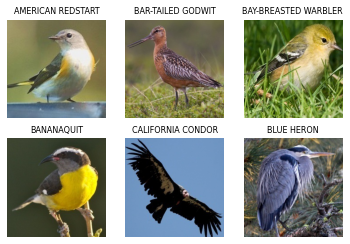

In [13]:

#create seperate labels for images 
def label_images2(DIR, dataset):
    label = []
    image = []
    j=0
    for i in range (0,30):
        j = random.randint(0, len(dataset.filenames))
        label.append(dataset.filenames[j].split('/')[0])
        image.append(DIR + '/' + dataset.filenames[j])
    return [label,image]

#plot the random images.
y,x = label_images2(TEST_DIR, test_data)

for i in range(0,6):
    X = load_img(x[i])
    plt.subplot(2,3,+1 + i)
    plt.axis(False)
    plt.title(y[i], fontsize=8)
    plt.imshow(X)
plt.show()

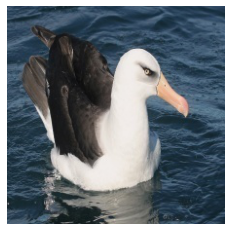

Figures are  (224, 224, 3)


In [14]:
#Load an image and determine image shape for analysis.
IMAGE = load_img(path+"ALBATROSS/001.jpg")
plt.imshow(IMAGE)
plt.axis("off")
plt.show()

IMAGEDATA = img_to_array(IMAGE)
SHAPE = IMAGEDATA.shape
print('Figures are ', SHAPE)

In [15]:
#This was my Sequential model from the CIFAR10 dataset - seemed like a good starting point. -65% accuracy
#With 2 epochs I got: Test loss: 2.3443613751181243 Test accuracy: 0.4788889
#With 50 epochs/stopped at 13 Test loss: 1.7568193797407479, Test accuracy: 0.5733333..Not so great. I will move on to pretrained models.
#Increased from 32 to 64 nodes in CONV2D layers: Test loss: 4.270853807186258, Test accuracy: 0.5377778
#Changed from Adam to sgd for optimizer:Test loss: 1.4400342908398858, Test accuracy: 0.65444446 - 65%

backend.clear_session()
model = Sequential()

model.add(Conv2D(64, (3, 3), padding='same',input_shape=SHAPE)) #224X224
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(Conv2D(64, (3, 3))) #222x222
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2))) #111x111
model.add(BatchNormalization())
model.add(Dropout(0.35)) #Doesn't appear to be working in the model summary.

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization()) 

model.add(Conv2D(64, (3, 3))) #109x109
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2))) #54x54
model.add(BatchNormalization())
model.add(Dropout(0.35)) #64 --> 42

model.add(Conv2D(64, (3, 3), padding='same')) #54x54
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(Flatten()) 
model.add(Dropout(0.5)) 
model.add(Dense(512)) 
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dense(Category_count)) #Updated for number of classes
model.add(Activation('softmax'))

model.summary()

#Compile
model.compile(optimizer = tf.keras.optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True),
               loss = 'categorical_crossentropy',
               metrics = ['accuracy'])
#fit model
history = model.fit_generator( 
    train_data, 
    steps_per_epoch = Train_groups, 
    epochs = 10,
    validation_data = validation_data,
    validation_steps = Valid_groups,
    verbose = 1,
    callbacks=[EarlyStopping(monitor='val_accuracy', patience = 5, restore_best_weights = True),
               ReduceLROnPlateau(monitor = 'val_loss', factor = 0.7, #0.2 to 0.5 dropped to fast 0.7
                                 patience = 2, verbose = 1)])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 activation (Activation)     (None, 224, 224, 64)      0         
                                                                 
 batch_normalization (BatchN  (None, 224, 224, 64)     256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 222, 222, 64)      36928     
                                                                 
 activation_1 (Activation)   (None, 222, 222, 64)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 64)     0         
 )                                                      

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/10
264/264 [==============================] - 1654s 6s/step - loss: 2.6739 - accuracy: 0.3466 - val_loss: 5.3198 - val_accuracy: 0.0441 - lr: 0.0010
Epoch 2/10
264/264 [==============================] - 64s 242ms/step - loss: 1.1850 - accuracy: 0.6936 - val_loss: 2.1095 - val_accuracy: 0.4373 - lr: 0.0010
Epoch 3/10
264/264 [==============================] - 64s 240ms/step - loss: 0.5984 - accuracy: 0.8604 - val_loss: 1.0847 - val_accuracy: 0.6881 - lr: 0.0010
Epoch 4/10
264/264 [==============================] - 63s 237ms/step - loss: 0.2690 - accuracy: 0.9565 - val_loss: 1.0395 - val_accuracy: 0.7186 - lr: 0.0010
Epoch 5/10
264/264 [==============================] - 63s 238ms/step - loss: 0.1235 - accuracy: 0.9914 - val_loss: 0.9551 - val_accuracy: 0.7356 - lr: 0.0010
Epoch 6/10
264/264 [==============================] - 63s 237ms/step - loss: 0.0735 - accuracy: 0.9975 - val_loss: 0.9533 - val_accuracy: 0.7322 - lr: 0.0010
Epoch 7/10
264/264 [==============================] -

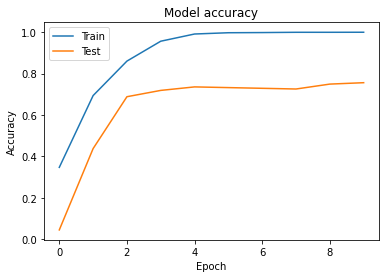

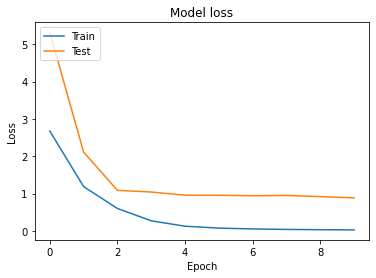

10/10 [==============================] - 77s 8s/step - loss: 0.9090 - accuracy: 0.7627
Test loss: 0.9089929461479187
Test accuracy: 0.7627118825912476


In [16]:
#plot accuracy vs epoch
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot loss values vs epoch
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Evaluate against test data.
scores = model.evaluate(test_data, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

In [17]:
#This would only be applied to my training data. looking at the data rotated within 40 degrees would give more data without a change to the mostly vertically sitting birds. 
Augment_datagen = ImageDataGenerator(rescale=1./255, rotation_range=40, # Rotate the images randomly by 40 degrees
    width_shift_range=0.2, # Shift the image horizontally by 20%
    height_shift_range=0.2, # Shift the image veritcally by 20%
    zoom_range=0.2, # Zoom in on image by 20% 
    horizontal_flip=True, # Flip image horizontally 
    fill_mode='nearest') 
Augmentation_train = Augment_datagen.flow_from_directory(TRAIN_DIR, target_size=(224,224))

print('data groups:', len(Augmentation_train)) #Will be used to determine steps_per_epoch in my models.

Found 8443 images belonging to 59 classes.
data groups: 264


In [18]:
model.save('./trained_model.h5')

In [19]:
from IPython.display import FileLink
FileLink(r'trained_model.h5')

/content/trained_model.h5

In [20]:
model2=models.load_model('./trained_model.h5')